In [ ]:
import os
from os.path import join
import functools, itertools
from collections import defaultdict, Counter
import re
import gzip
import warnings

In [404]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyslim as psl

In [479]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [ ]:
data_dir = '../data/slim_sims/polygenic_nonwf/'

In [608]:
def iter_results(dir, tails={'_log.tsv.gz':'log', '_treeseq.tree':'tree'}):
    "Iterate through the paired results of (log file, tree sequence file)"
    files = sorted(os.listdir(dir))
    groups = defaultdict(dict)
    tails_str = '|'.join(tails.keys())
    key_re = re.compile(f"(?P<key>.*)(?P<tail>{tails_str})")
    for file in files:
        match = key_re.match(file)
        if match is None:
            raise ValueError(f"file {file} does not match regular expression")
        key = match.groupdict()['key']
        tail = match.groupdict()['tail']
        groups[key][tails[tail]] = file
    return groups

def combine_results(results_dict, converter, datadir=None, ignore_keys=['rep']):
    """Take the results dict, read in parameters, figure out whether 
    population went extinct"""
    data = defaultdict(list)
    for key, files in results_dict.items():
        logfile = files['log']
        treefile = files.get('tree', None)
        
        # this way we can join without check if None:
        datadir = '' if datadir is None else datadir
        logfile = join(datadir, logfile)
        if treefile is not None:
            treefile = join(datadir, treefile)
        
        with gzip.open(logfile, 'rb') as f:
            line = next(f).decode().strip()
            assert(line.startswith('#'))
            keyvals = [x.split('=') for x in line[1:].split(';') if len(x) > 0]
            params = {k: converter[k](v) for k, v in keyvals}
            try:
                df = pd.read_csv(f, delimiter='\t')
            except pd.errors.EmptyDataError:
                continue
        
        diversity = None
        if treefile is not None:
            # ignore some pyslim warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                diversity = psl.load(treefile).diversity()
        last_gen = max(df['generation'].values)
        extinct = last_gen < params['end']
        df['extinct'] = extinct
        df['last_gen'] = last_gen
        df['diversity'] = diversity
        df['burnin'] = 10 * params['K']
        for param, value in params.items():
            df[param] = value
        tuple_key = tuple([(k, v) for k, v in params.items() if k not in ignore_keys])
        data[tuple_key].append(df)
    return data


resfiles = iter_results(data_dir)

converter = dict(K=int, alpha=float, Vs=float, end=int, fitfunc=str, 
                 moving_bm=lambda x: {'T':True, 'F':False}[x], 
                 s=float, h=float,
                 muN=float, muT=float, muD=float, optimasd=float, rbp=float, rep=int)
res = combine_results(resfiles, converter, datadir=data_dir, ignore_keys=['rep', 'end'])

In [614]:
resfiles

defaultdict(dict,
            {'polygenic_nonwf_rep0_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08': {'log': 'polygenic_nonwf_rep0_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08_log.tsv.gz'},
             'polygenic_nonwf_rep10_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08': {'log': 'polygenic_nonwf_rep10_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08_log.tsv.gz'},
             'polygenic_nonwf_rep11_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08': {'log': 'polygenic_nonwf_rep11_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08_log.tsv.gz'},
             'polygenic_nonwf_rep12_Vs1_fitfuncmoving_optimasd0.1_moving_bmF_K500_alpha0.01_s0_h0_muT1e-07_muN5e-08_muD0_rbp1e-08': {'log': 'polygenic_nonwf_rep12_Vs1_fitf

In [611]:
list(res)[0]

(('K', 500),
 ('Vs', 1.0),
 ('alpha', 0.01),
 ('fitfunc', '"moving"'),
 ('h', 0.0),
 ('moving_bm', False),
 ('muD', 0.0),
 ('muN', 5e-08),
 ('muT', 1e-07),
 ('optimasd', 0.1),
 ('rbp', 1e-08),
 ('s', 0.0))

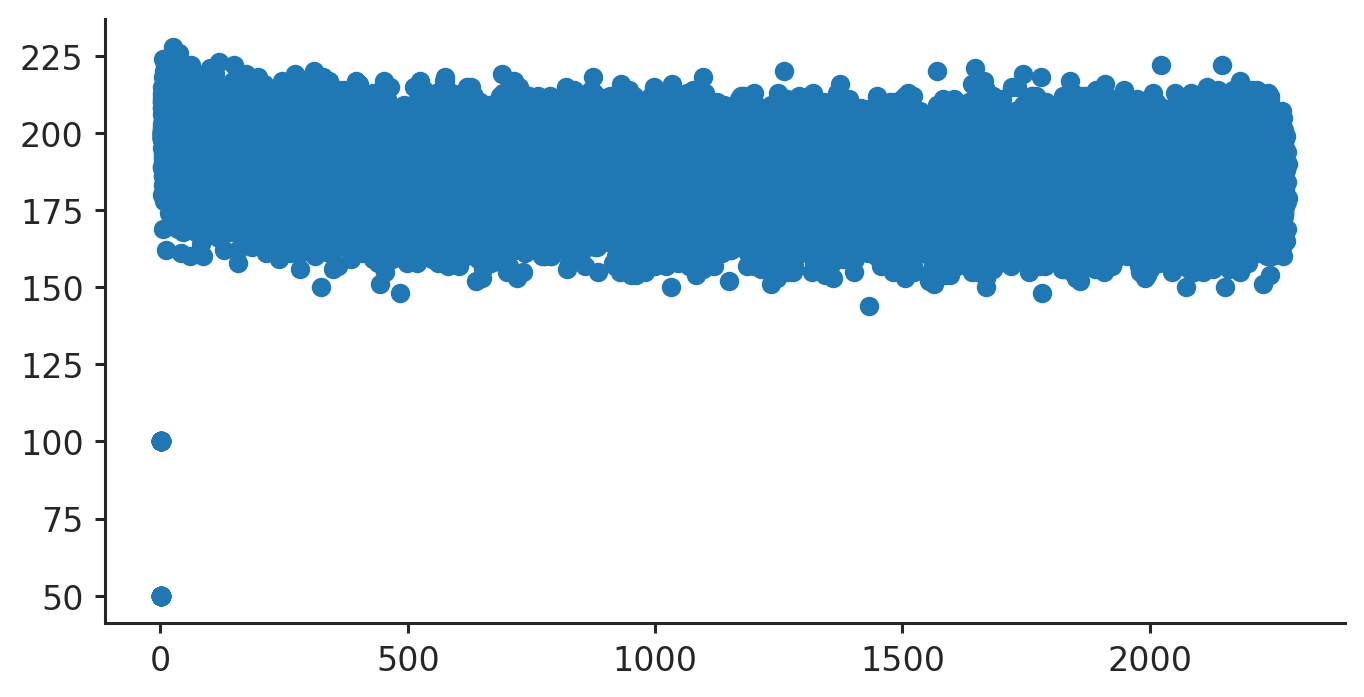

In [617]:
key = (('K', 500),
 ('Vs', 1.0),
 ('alpha', 0.01),
 ('fitfunc', '"moving"'),
 ('h', 0.0),
 ('moving_bm', False),
 ('muD', 0.0),
 ('muN', 5e-08),
 ('muT', 1e-07),
 ('optimasd', 0.1),
 ('rbp', 1e-08),
 ('s', 0.0))

dd = pd.concat(res[key])
#plt.scatter(dd['generation'], dd['z_mean'])
#plt.scatter(dd['generation'], dd['optima'])

plt.scatter(dd['generation'], dd['N'])
#plt.scatter(dd['generation'], dd['optima'])

In [590]:
list(res.keys( ))[0]

(('K', 450),
 ('Vs', 1.0),
 ('alpha', 0.01),
 ('fitfunc', '"moving"'),
 ('h', 0.0),
 ('moving_bm', False),
 ('muD', 0.0),
 ('muN', 5e-08),
 ('muT', 1e-07),
 ('optimasd', 0.1),
 ('rbp', 1e-08),
 ('s', 0.0))

In [591]:
dx = pd.concat(res[(('K', 500),
 ('Vs', 1.0),
 ('alpha', 0.01),
 ('fitfunc', '"moving"'),
 ('h', 0.3),
 ('moving_bm', False),
 ('muD', 1e-09),
 ('muN', 5e-08),
 ('muT', 1e-08),
 ('optimasd', 0.01),
 ('rbp', 1e-08),
 ('s', 0.001))])

print(np.unique(dx['extinct'], return_counts=True))
plt.scatter(dx['generation'], dx['N'], c=dx['rep'], s=1)
plt.axvline(dx['burnin'].unique(), 0, 10000, c='r')
plt.ylabel("pop size")
plt.xlabel("generation")

ValueError: No objects to concatenate

In [563]:
np.unique(dx['extinct'], return_counts=True)

(array([False]), array([100000]))

In [588]:
500 * 0.1

50.0

No handles with labels found to put in legend.


Text(0.5, 0, 'population size')

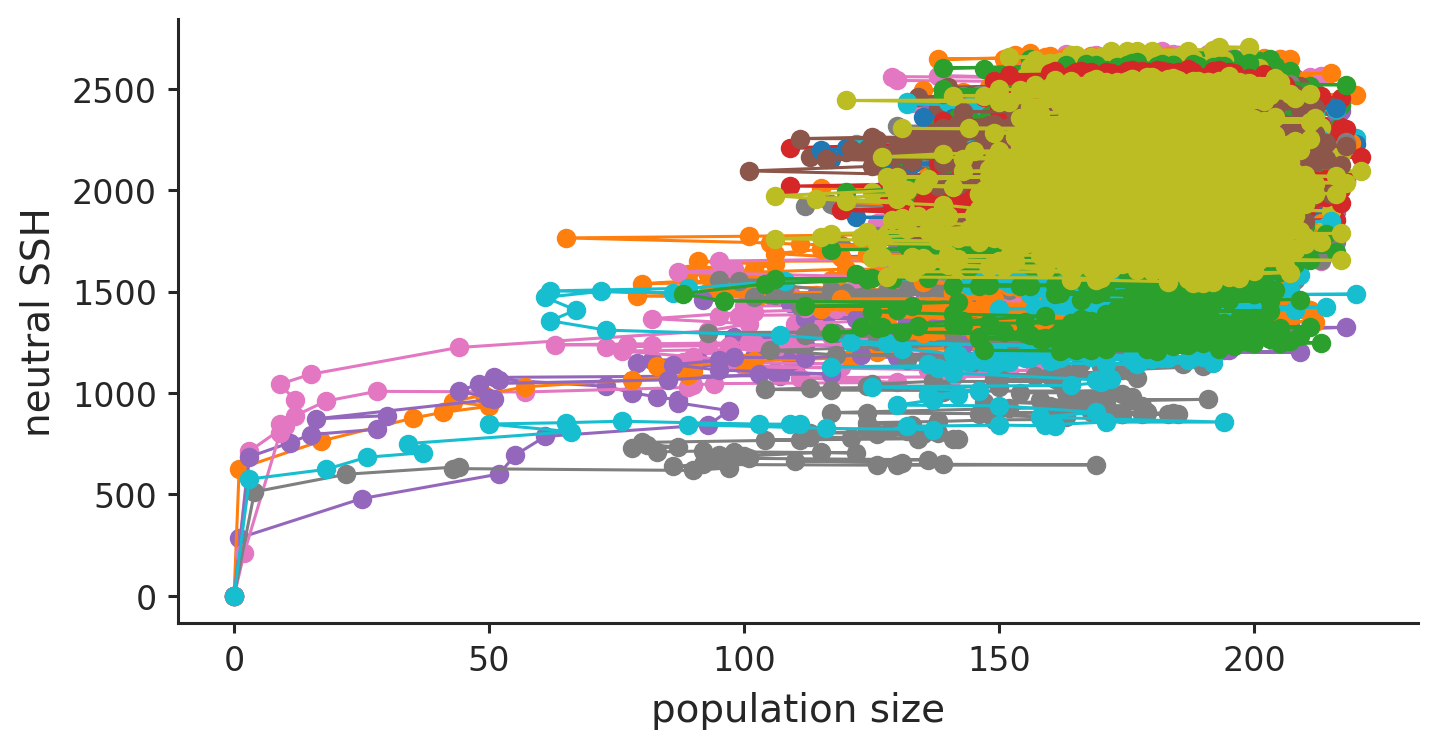

In [535]:
dn = dx.loc[dx['generation'] > dx['burnin'].unique()[0], ]

fig, ax = plt.subplots()
for i in (True, False):
    for r in dn['rep'].unique():
        dd = dn.loc[(dn['extinct'] == i) & (dn['rep'] == r)]
        scatter = ax.plot(dd['N'], dd['sshN'], '-o', alpha=1)

ax.legend()
ax.set_ylabel('neutral SSH')
ax.set_xlabel('population size')

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/vsb/miniconda3/envs/bioinfo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/vsb/miniconda3/envs/bioinfo/lib/python3.8/site-packages/matplotlib/ticker.py:665: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


Text(0.5, 0, '| z - optima |')

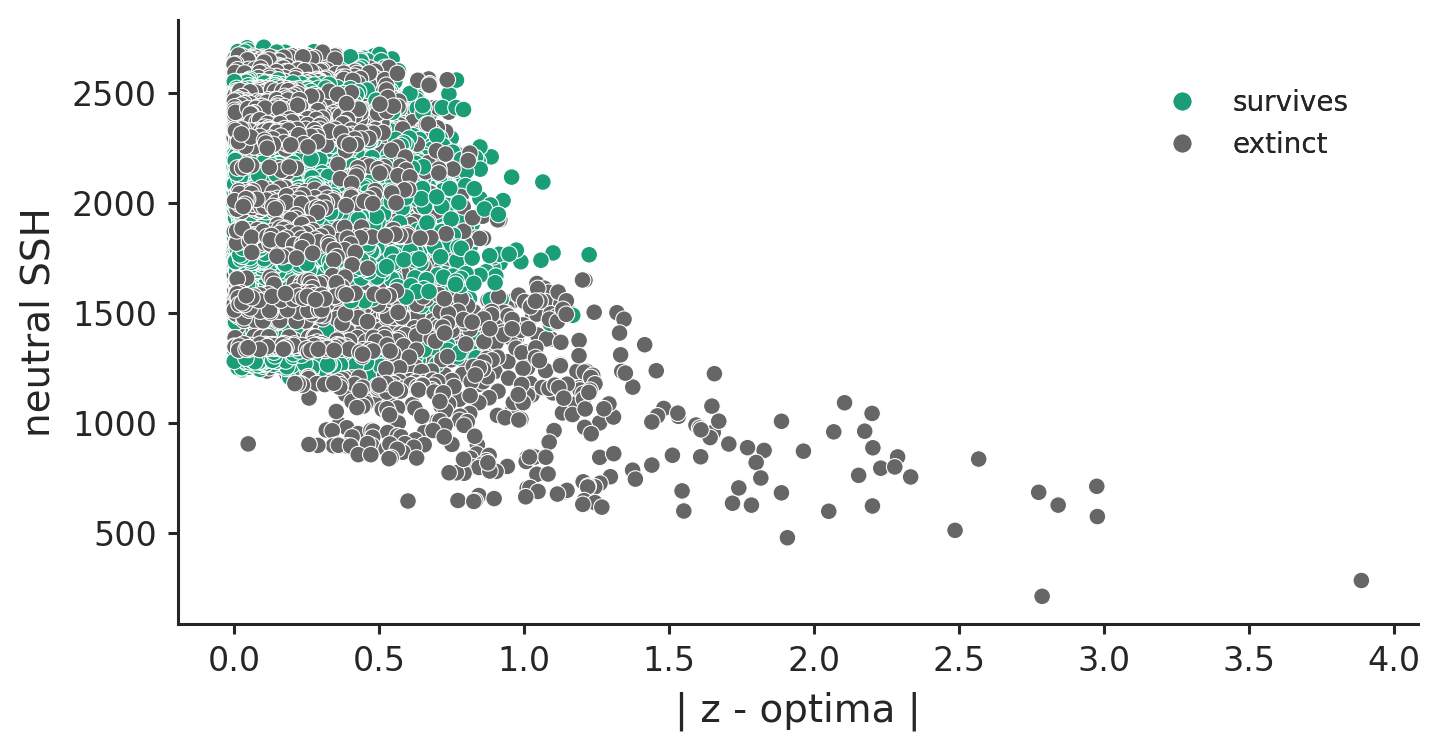

In [498]:
dn = dx.loc[dx['generation'] > dx['burnin'].unique()[0], ]

fig, ax = plt.subplots()
scatter = ax.scatter(np.abs(dn['z_mean'] - dn['optima']), dn['sshN'], c=dn['extinct'], alpha=1, cmap='Dark2', edgecolor='white', linewidth=0.4)

legels = scatter.legend_elements()
legels = (legels[0], ('survives', 'extinct'))
legend = ax.legend(*legels, loc="upper right", title="")
ax.add_artist(legend)
ax.set_ylabel('neutral SSH')
ax.set_xlabel('| z - optima |')

Text(0.5, 0, '| optima |')

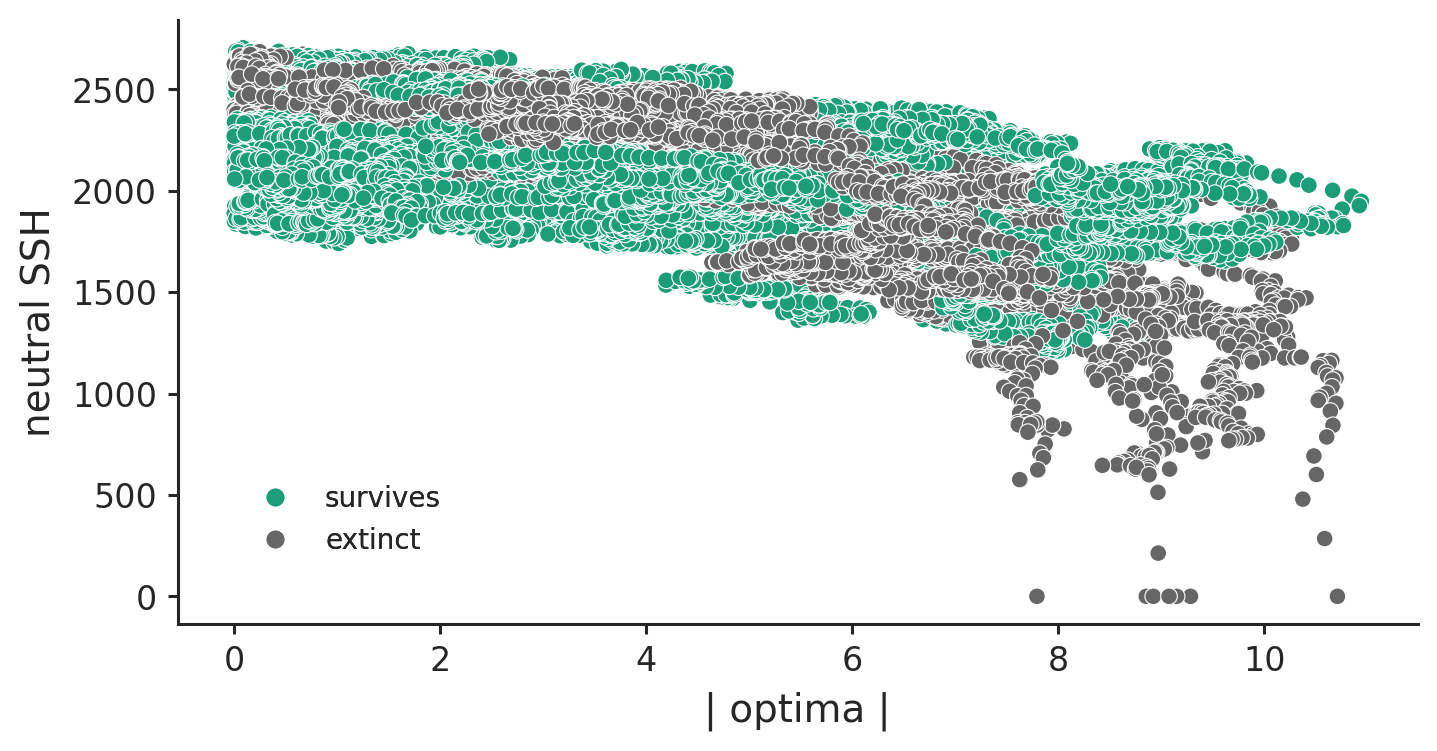

In [500]:
dn = dx.loc[dx['generation'] > dx['burnin'].unique()[0], ]

fig, ax = plt.subplots()
scatter = ax.scatter(np.abs(dn['optima']), dn['sshN'], c=dn['extinct'], alpha=1, cmap='Dark2', edgecolor='white', linewidth=0.4)

legels = scatter.legend_elements()
legels = (legels[0], ('survives', 'extinct'))
legend = ax.legend(*legels, loc="lower left", title="")
ax.add_artist(legend)
ax.set_ylabel('neutral SSH')
ax.set_xlabel('| optima |')

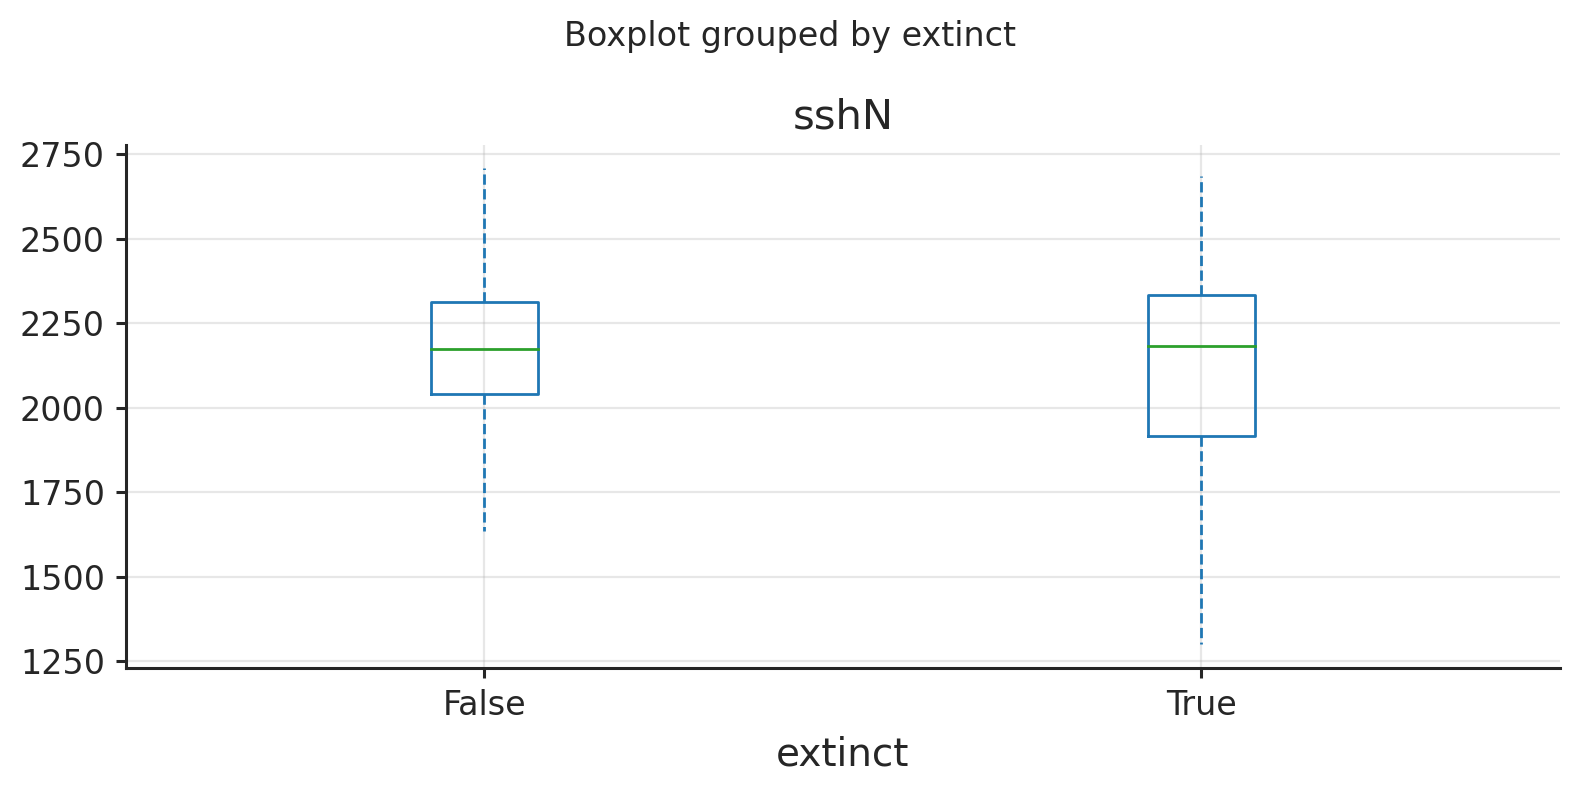

In [496]:
dn = dx.loc[(dx['generation'] > dx['burnin'].unique()[0]) & (dx['N'] > 150), ]
dn.boxplot('sshN', 'extinct')
plt.tight_layout()

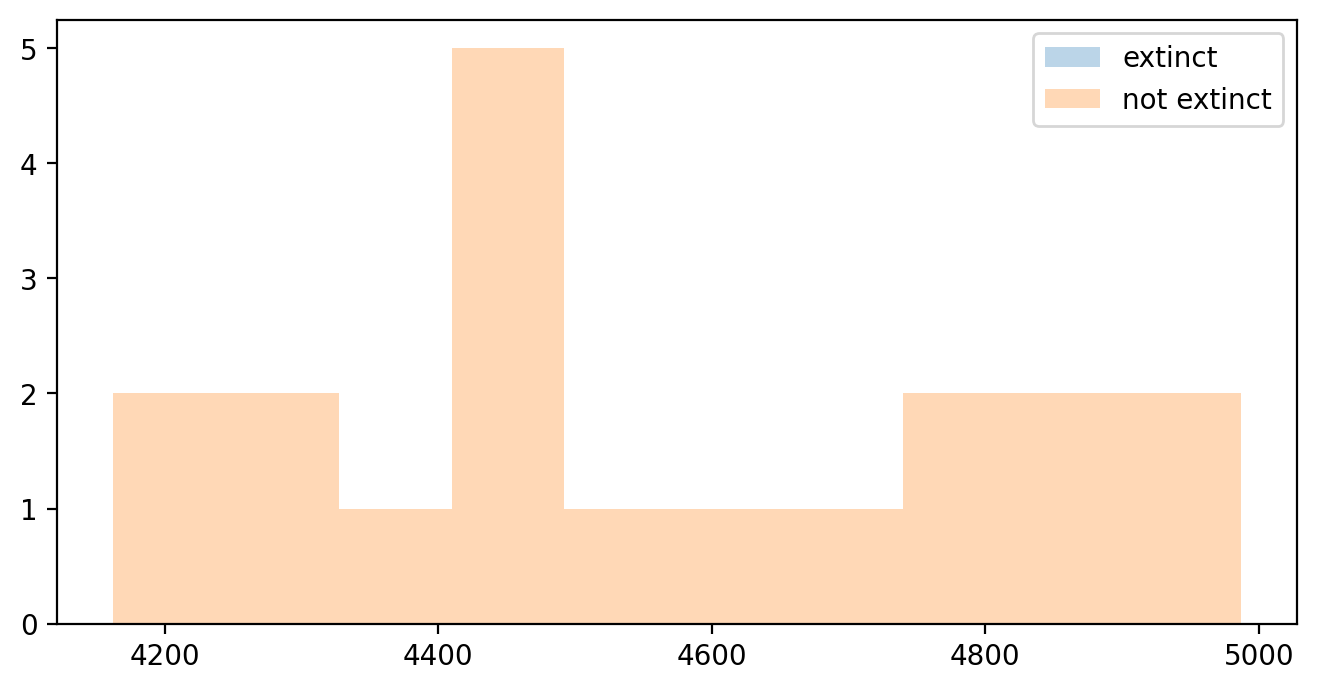

In [456]:
da = dx.loc[dx['generation'] == dx['burnin'].unique()[0] + 10, ]
plt.hist(da.loc[da['extinct'], 'sshN'], label='extinct', alpha=0.3)
plt.hist(da.loc[~da['extinct'], 'sshN'], label='not extinct', alpha=0.3)
plt.legend()

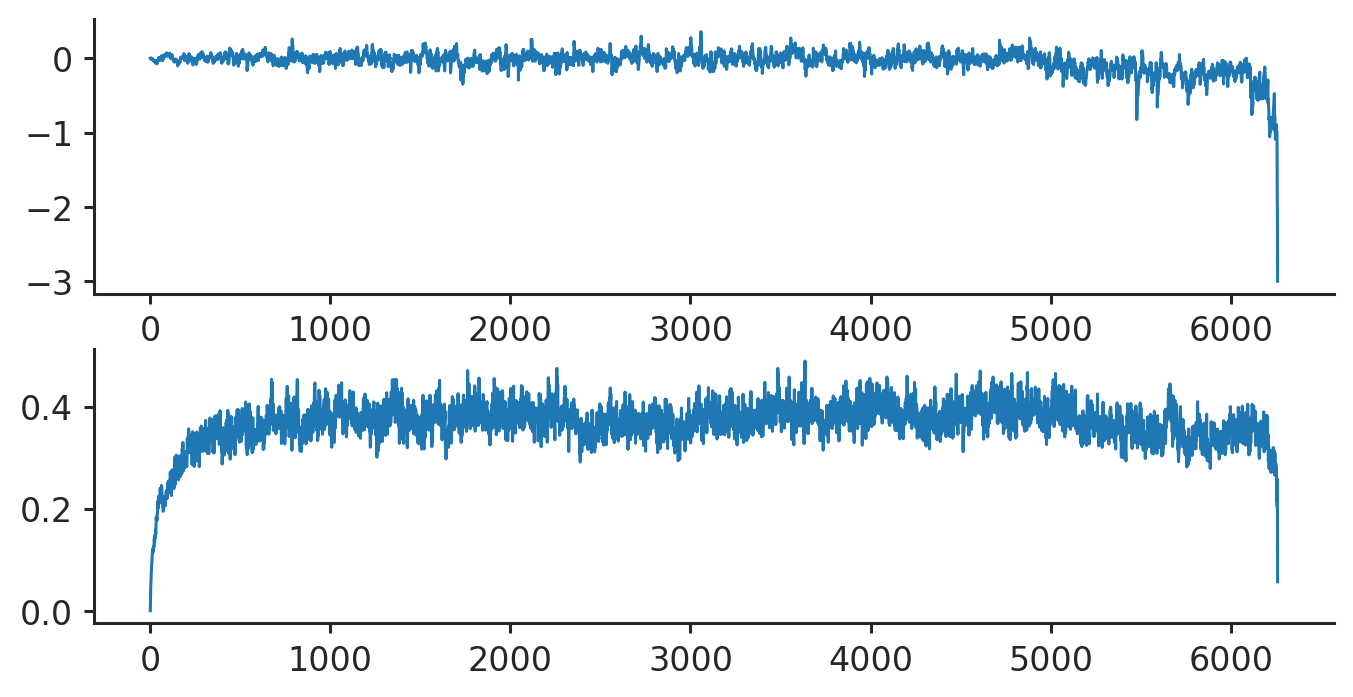

In [519]:
dx = pd.concat(res[(('K', 500),
                    ('Vs', 1.0),
                    ('alpha', 0.01),
                    ('fitfunc', '"moving"'),
                    ('moving_bm', False),
                    ('muN', 5e-08),
                    ('muT', 1e-07),
                    ('optimasd', 0.01),
                    ('rbp', 1e-08))])
dx = dx.loc[dx['rep'] == 2]
#plt.plot(dx['generation'], dx['z_mean'])
#plt.plot(dx['generation'], dx['optima'])

fig, ax = plt.subplots(ncols=1, nrows=2)
ax[0].plot(dx['generation'], (dx['z_mean'] - dx['optima']))
ax[1].plot(dx['generation'], dx['z_sd'])

In [421]:
stats.norm.pdf(0,)

0.3989422804014327

In [415]:
burnin_ssh = dx.loc[dx['generation'] == dx['burnin'].unique()[0], ]
#burnin_ssh.boxplot('sshN', 'extinct')
ex = burnin_ssh.loc[burnin_ssh['extinct'], 'sshN'].values
non_ex = burnin_ssh.loc[~burnin_ssh['extinct'], 'sshN'].values
non_ex
stats.ttest_ind(non_ex, ex)

Ttest_indResult(statistic=0.4281588789764405, pvalue=0.6736147472938492)

In [347]:
d.groupby(params)

In [351]:
d.loc[(d['K'] == 1000) & (d['alpha'] == 0.01) & (d['Vs'] == 1.0) & (d['fitfunc'] == "moving") & 
  (d['moving_bm'] == False) & (d['muN'] == 5e-08) & (d['muT'] == 1e-07) & (d['optimasd'] == 0.1) & (d['rbp'] == 1e-08), ]

,generation,z_mean,z_sd,optima,N,nmutN_mean,nmutN_sd,nmutT_mean,nmutT_sd,sshN,...,alpha,end,fitfunc,moving_bm,muN,muT,optimasd,rbp,rep,shift_gen


In [298]:
d1k = d.loc[(d['K'] == 1000) & (d['optimasd'] == 0.1) & (d['muT'] == 1e-7) & (d['moving_bm'] == True)]

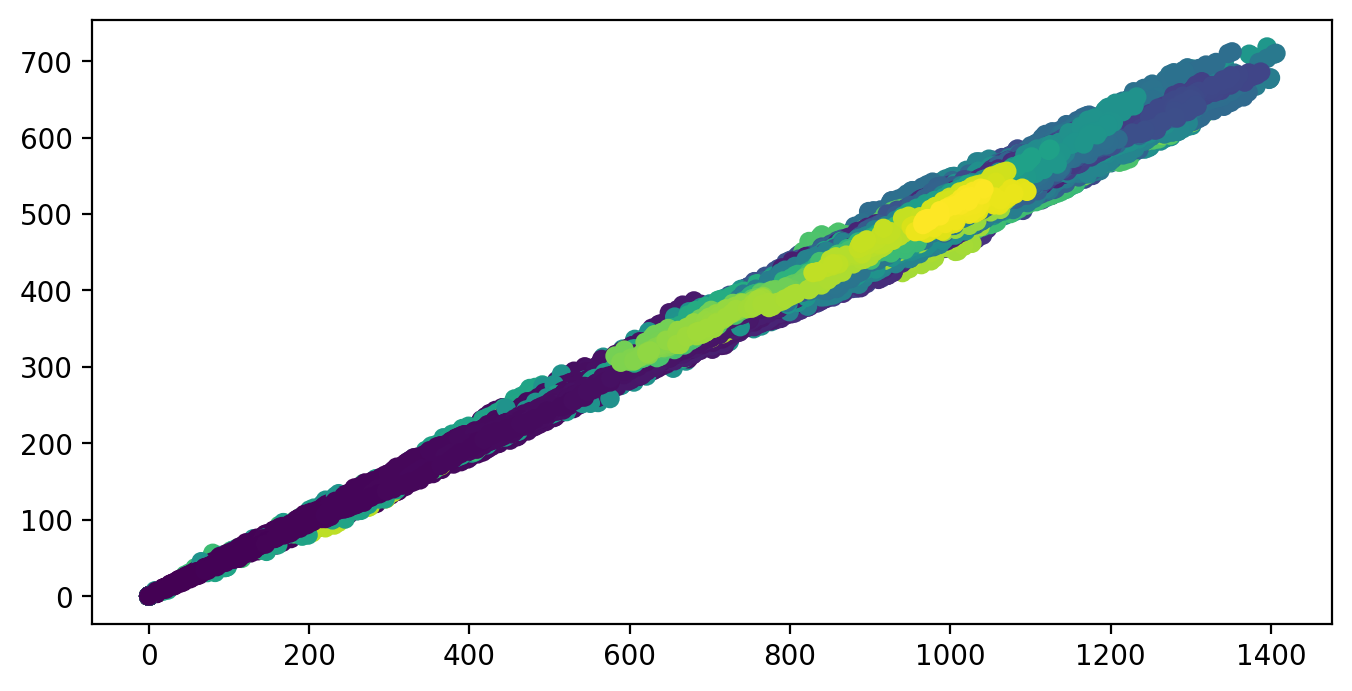

In [311]:
plt.scatter(d['sshT'], d['sshN'], c=d['generation'])

In [321]:
np.unique(d['muT'], return_counts=True)

(array([1.e-07]), array([45116]))

In [320]:
d.head()

,generation,z_mean,z_sd,optima,N,nmutN_mean,nmutN_sd,nmutT_mean,nmutT_sd,sshN,...,alpha,end,fitfunc,moving_bm,muN,muT,optimasd,rbp,rep,shift_gen
0,1,0.000000,0.000000,0.0,10,0.0000,0.00000,0.0000,0.0000,0.00000,...,0.01,2000,"""moving""",False,5.000000e-08,1.000000e-07,0.1,1.000000e-08,11,999
1,2,0.007500,0.031933,0.0,20,5.0000,5.47723,9.4500,10.0393,4.87500,...,0.01,2000,"""moving""",False,5.000000e-08,1.000000e-07,0.1,1.000000e-08,11,999
2,3,-0.001000,0.044595,0.0,40,9.6250,7.09166,18.5500,13.2316,9.43156,...,0.01,2000,"""moving""",False,5.000000e-08,1.000000e-07,0.1,1.000000e-08,11,999
3,4,0.001538,0.067689,0.0,39,13.5641,8.45668,27.4359,15.3225,13.22650,...,0.01,2000,"""moving""",False,5.000000e-08,1.000000e-07,0.1,1.000000e-08,11,999
4,5,-0.003529,0.075473,0.0,34,18.6471,8.14595,38.8235,14.8619,18.11940,...,0.01,2000,"""moving""",False,5.000000e-08,1.000000e-07,0.1,1.000000e-08,11,999


<AxesSubplot:title={'center':'nmutN_mean'}, xlabel='[extinct, moving_bm]'>

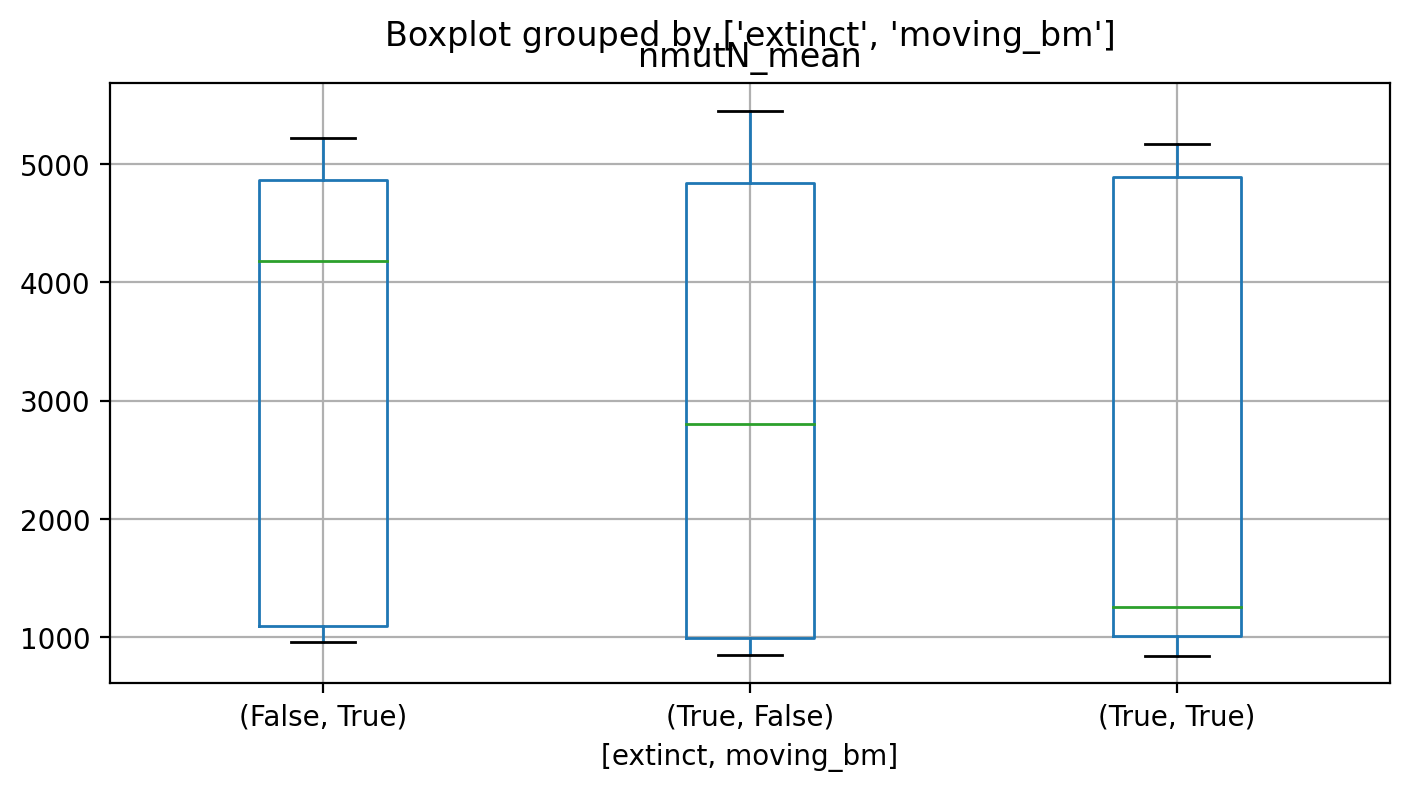

In [331]:
d['shift_gen'] = 10 * d['K'] - 1
d.loc[d['shift_gen'] == d['generation']].boxplot('nmutN_mean', ['extinct', 'moving_bm'])

In [307]:
100e6 * 1e-7 * 1000

10000.0

<AxesSubplot:title={'center':'diversity'}, xlabel='[extinct]'>

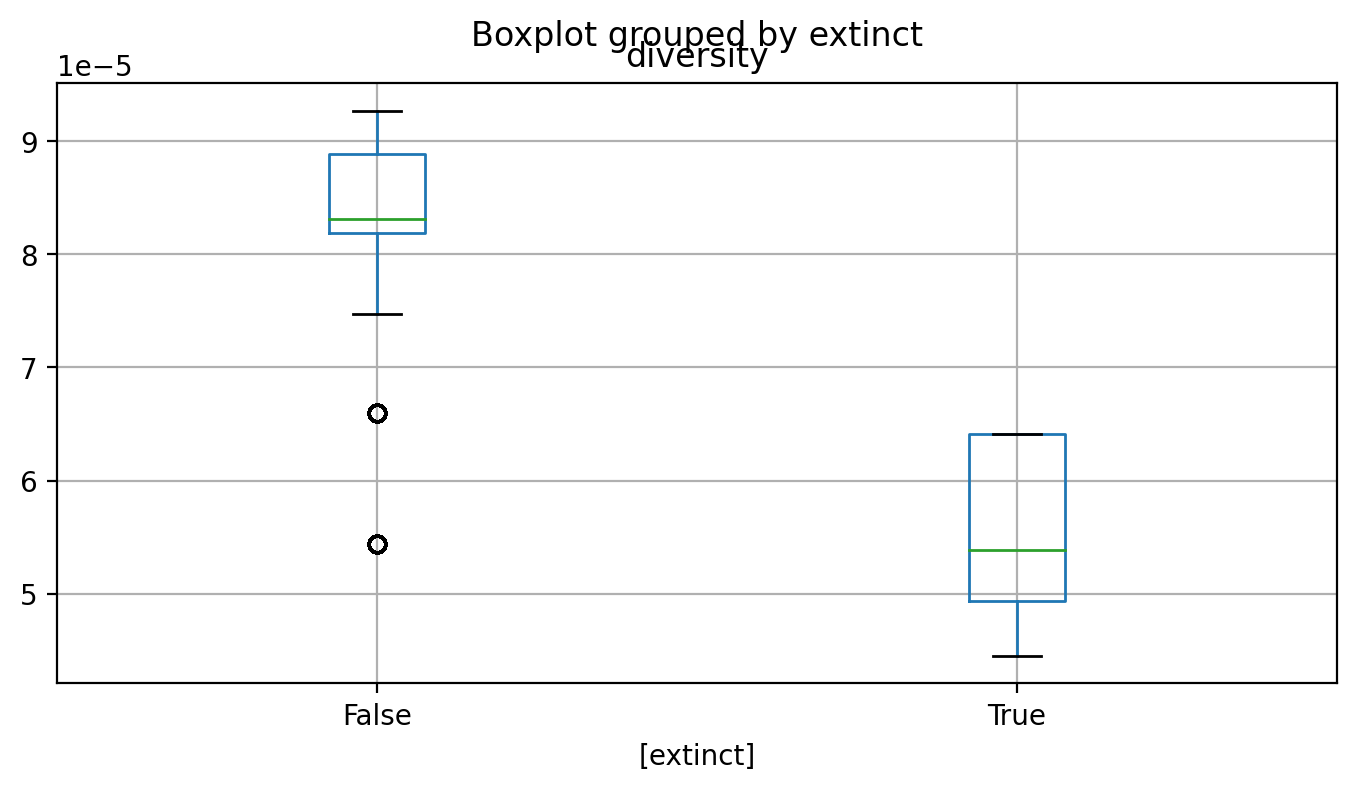

In [259]:
d1k.boxplot('diversity', ['extinct'])

In [260]:
d1k.head()

,generation,z_mean,z_sd,nmuts_mean,nmuts_sd,optima,N,extinct,diversity,K,Vs,alpha,end,fitfunc,moving_bm,muN,muT,optimasd,rbp,rep
0,1,0.000000,0.000000,0.0000,0.0000,0.0,100,False,0.000089,1000,1.0,0.01,20000,"""moving""",True,0.0,1.000000e-07,0.1,1.000000e-08,0
1,2,-0.000500,0.032528,10.0700,10.5509,0.0,200,False,0.000089,1000,1.0,0.01,20000,"""moving""",True,0.0,1.000000e-07,0.1,1.000000e-08,0
2,3,-0.000377,0.048464,20.1734,14.1105,0.0,398,False,0.000089,1000,1.0,0.01,20000,"""moving""",True,0.0,1.000000e-07,0.1,1.000000e-08,0
3,4,-0.000026,0.055966,29.9767,16.2457,0.0,386,False,0.000089,1000,1.0,0.01,20000,"""moving""",True,0.0,1.000000e-07,0.1,1.000000e-08,0
4,5,0.004396,0.063257,39.7488,18.1223,0.0,414,False,0.000089,1000,1.0,0.01,20000,"""moving""",True,0.0,1.000000e-07,0.1,1.000000e-08,0


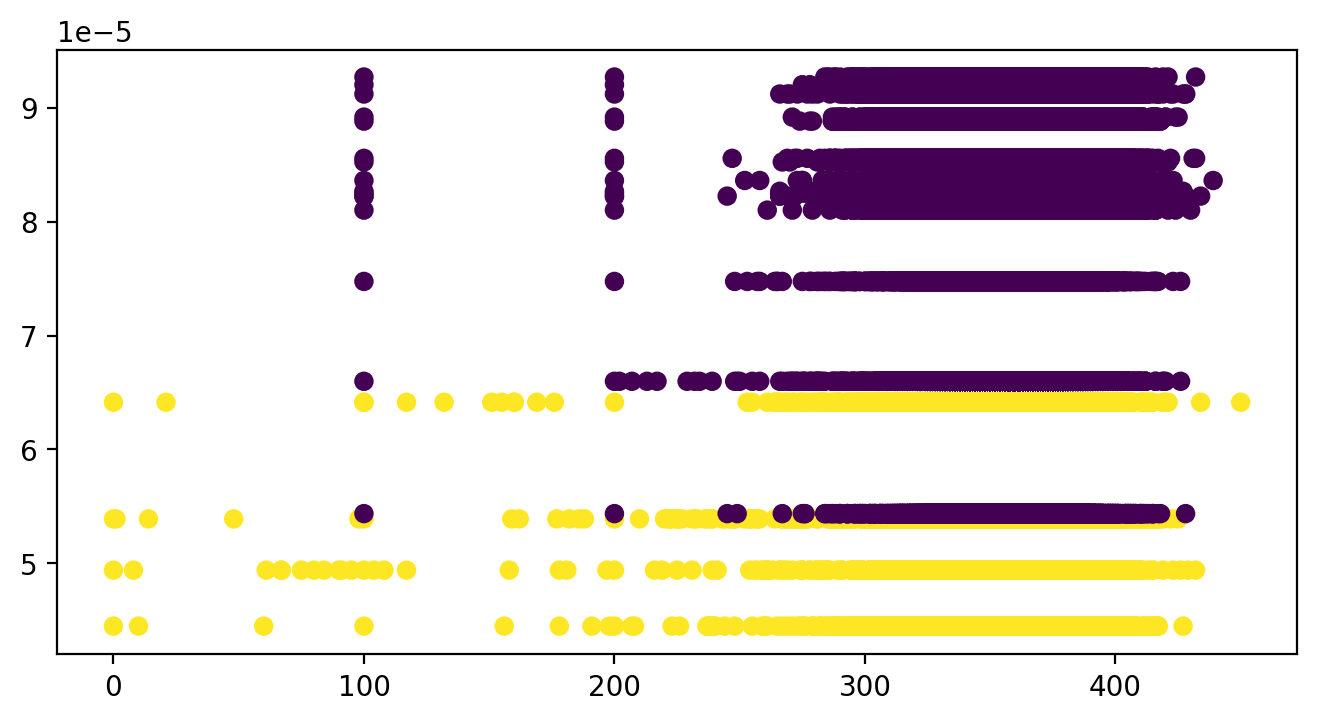

In [263]:
plt.scatter(d1k['N'], d1k['diversity'], c=d1k['extinct'])

In [211]:
y = [r['diversity'] for r in res.values() if r['params']['K'] == 1000]
ex = np.array([r['extinct'] for r in res.values() if r['params']['K'] == 1000])
print(Counter(ex))
x = [r['log']['z_sd'].values[-1] for r in res.values() if r['params']['K'] == 1000]


Counter({True: 264, False: 16})


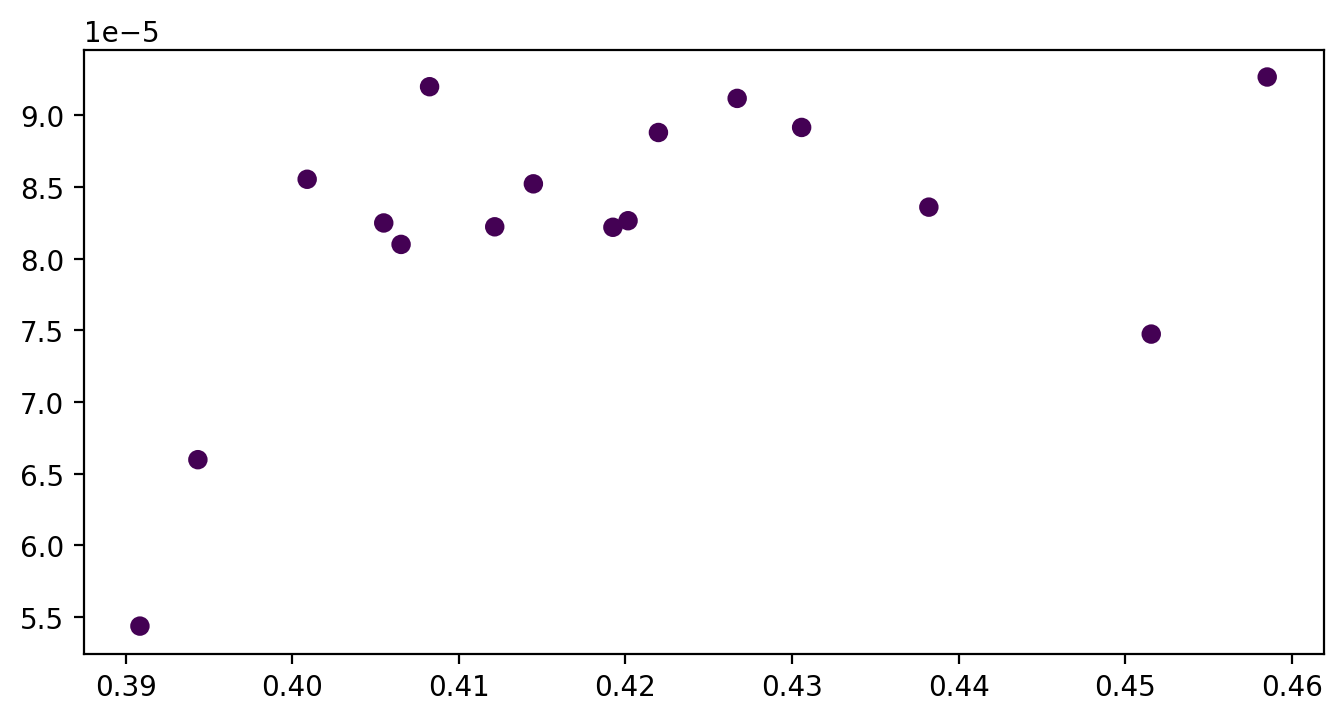

In [212]:
plt.scatter(x, y, c=ex.astype('int'))

In [141]:
file = 'polygenic_nonwf_rep17_Vs1_fitfuncmoving_optimasd1_moving_bmT_K1000_alpha0.01_muT1e-07_muN0_rbp1e-08_log.tsv.gz'
dl = pd.read_csv(join(data_dir, file), delimiter='\t', comment='#')

In [144]:
dl.tail()

,generation,z_mean,z_sd,nmuts_mean,nmuts_sd,optima,N
10054,10055,0.730151,0.410139,11909.9,75.4782,-0.92660,66
10055,10056,0.379841,0.378151,11930.7,73.8434,-1.27199,63
10056,10057,0.122969,0.353628,11495.6,79.3979,-1.55843,64
10057,10058,-0.520714,0.488474,10855.4,88.0687,-2.84414,14
10058,10059,NaN,NaN,NaN,NaN,-3.17441,0


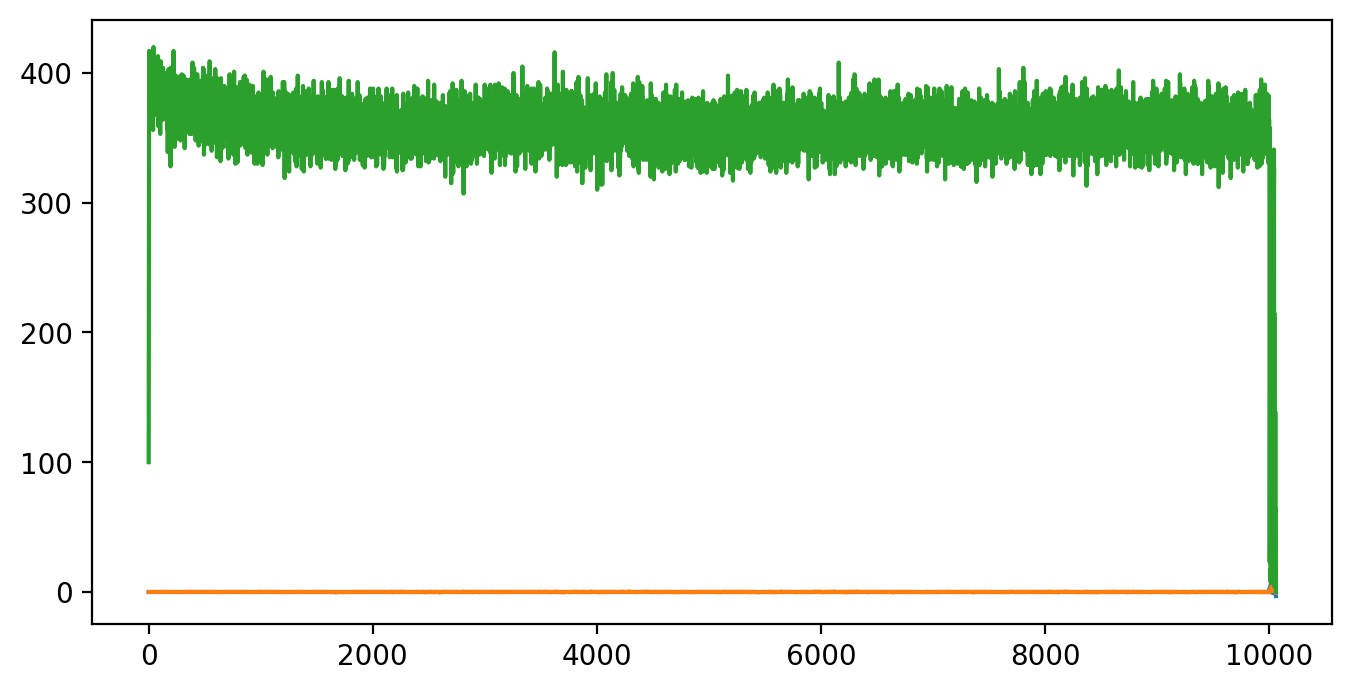

In [143]:
plt.plot(dl.generation, dl.optima)
plt.plot(dl.generation, dl.z_mean)
plt.plot(dl.generation, dl.N)

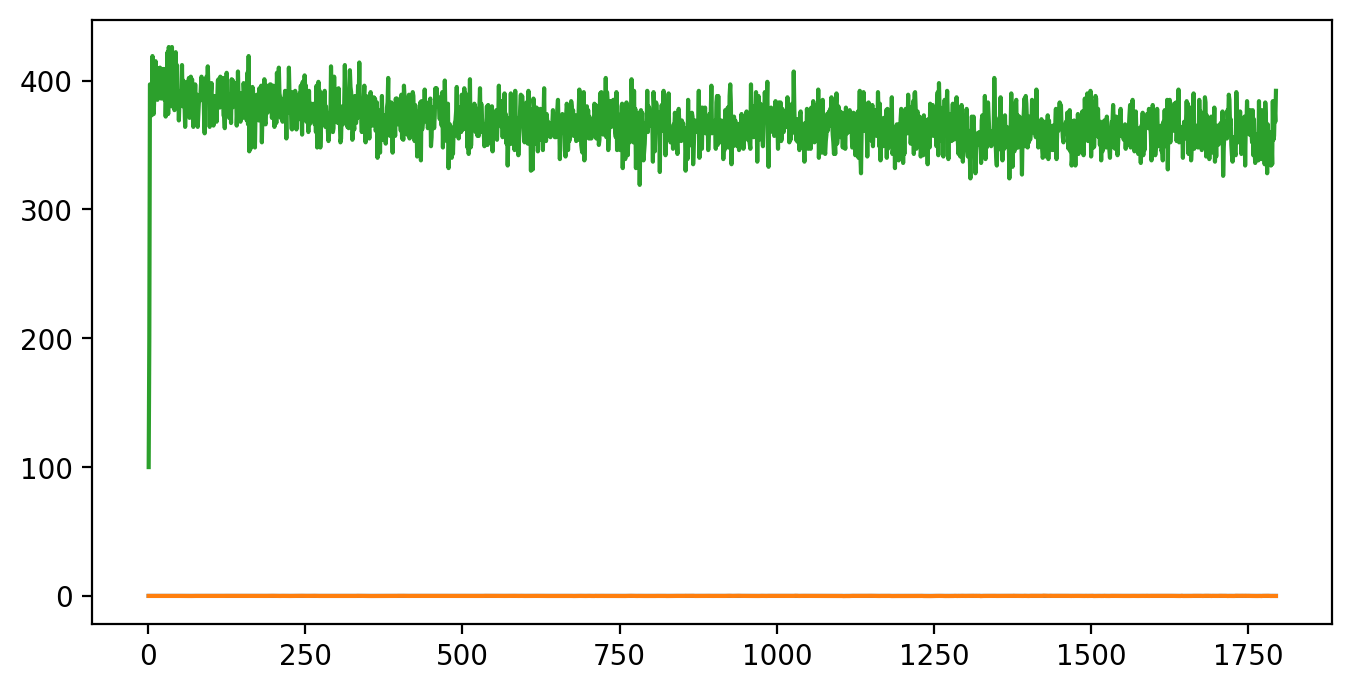

In [128]:
plt.plot(dl.generation, dl.optima)
plt.plot(dl.generation, dl.z_mean)
plt.plot(dl.generation, dl.N)

In [69]:
file = '../data/slim_sims/polygenic_Vs1_fitfuncoptimashift_optimasdNA_optima_shift0.5_K500_alpha0.01_muT1e-08_muN0_rbp1e-08_treeseq.tree'
ts = psl.load(file)

/home/vsb/miniconda3/envs/bioinfo/lib/python3.8/site-packages/pyslim/slim_tree_sequence.py:868: UserWarning: This is an version 0.6 SLiM tree sequence. When you write this out, it will be converted to version 0.5.
  warnings.warn("This is an version {} SLiM tree sequence.".format(file_version) +


In [70]:
ts.diversity()

array(5.83664564e-06)